In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
with open('data/train.json', 'r') as f:
    data = json.load(f)

In [3]:
data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [4]:
df = pd.DataFrame(data['annotations'])
print(df.shape)
df.head()

(15774, 8)


,segmentation,area,iscrowd,image_id,bbox,category_id,id,ignore
0,"[[52, 86, 52, 420, 471, 420, 471, 86]]",139946,0,2008000008,"[52, 86, 419, 334]",13,1,0
1,"[[157, 43, 157, 167, 289, 167, 289, 43]]",16368,0,2008000008,"[157, 43, 132, 124]",15,2,0
2,"[[269, 0, 269, 176, 378, 176, 378, 0]]",19184,0,2008000015,"[269, 0, 109, 176]",5,3,0
3,"[[56, 0, 56, 150, 164, 150, 164, 0]]",16200,0,2008000015,"[56, 0, 108, 150]",5,4,0
4,"[[138, 1, 138, 197, 372, 197, 372, 1]]",45864,0,2008000019,"[138, 1, 234, 196]",12,5,0


In [5]:
df.iscrowd.value_counts(), df.ignore.value_counts()

(iscrowd
 0    15774
 Name: count, dtype: int64,
 ignore
 0    13609
 1     2165
 Name: count, dtype: int64)

In [6]:
id2label = {d['id']:d['name'] for d in data['categories']}
len(id2label)

20

In [7]:
id2img = {d['id']:'data/train/'+d['file_name'] for d in data['images']}

In [8]:
df = df.query('ignore!=1').drop(columns=['segmentation','ignore'])
agg_df = df.groupby('image_id').agg(list).reset_index()

In [9]:
img_id, gtbbs, cat_ids = agg_df.loc[3,['image_id','bbox','category_id']]

In [10]:
def show_bbs(img_path, bboxes, labels=None, ax=None):
    img = plt.imread(img_path)
    if ax is None: _, ax = plt.subplots(1)
    ax.imshow(img)
    for i, bbox in enumerate(bboxes):
        xmin, ymin, w, h = bbox
        rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(xmin+5, ymin+10, labels[i], color='black', fontsize=8, backgroundcolor='white')
    ax.axis('off')  # Hide axes for better visualization

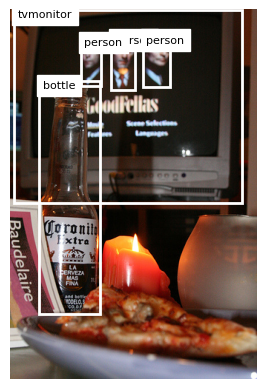

In [11]:
img_path = id2img[img_id]
labels = [id2label[cat_id] for cat_id in cat_ids]

show_bbs(img_path, gtbbs, labels)

In [12]:
def show_imgs(ann_file, nrows, id2label, id2img):
    data = json.load(open(ann_file))
    if type(data)==dict: data = data['annotations']
    df = pd.DataFrame(data).groupby('image_id').agg(list)
    sample = df.sample(nrows*3)
    
    _, axes = plt.subplots(nrows, 3, figsize=(15, 5*nrows))
    for ax, (img_id, row) in zip(axes.flatten(), sample.iterrows()):
        img_path = id2img[img_id]
        cat_ids, bboxes = row[['category_id','bbox']]
        titles = [id2label[id] if id!=0 else 'bg' for id in cat_ids]
        if 'score' in row:
            scores = row['score']
            titles = [f'{l}, {score:.2f}' for l, score in zip(titles, scores)]
        show_bbs(img_path, bboxes, titles, ax)
        
    plt.tight_layout()
    plt.show()

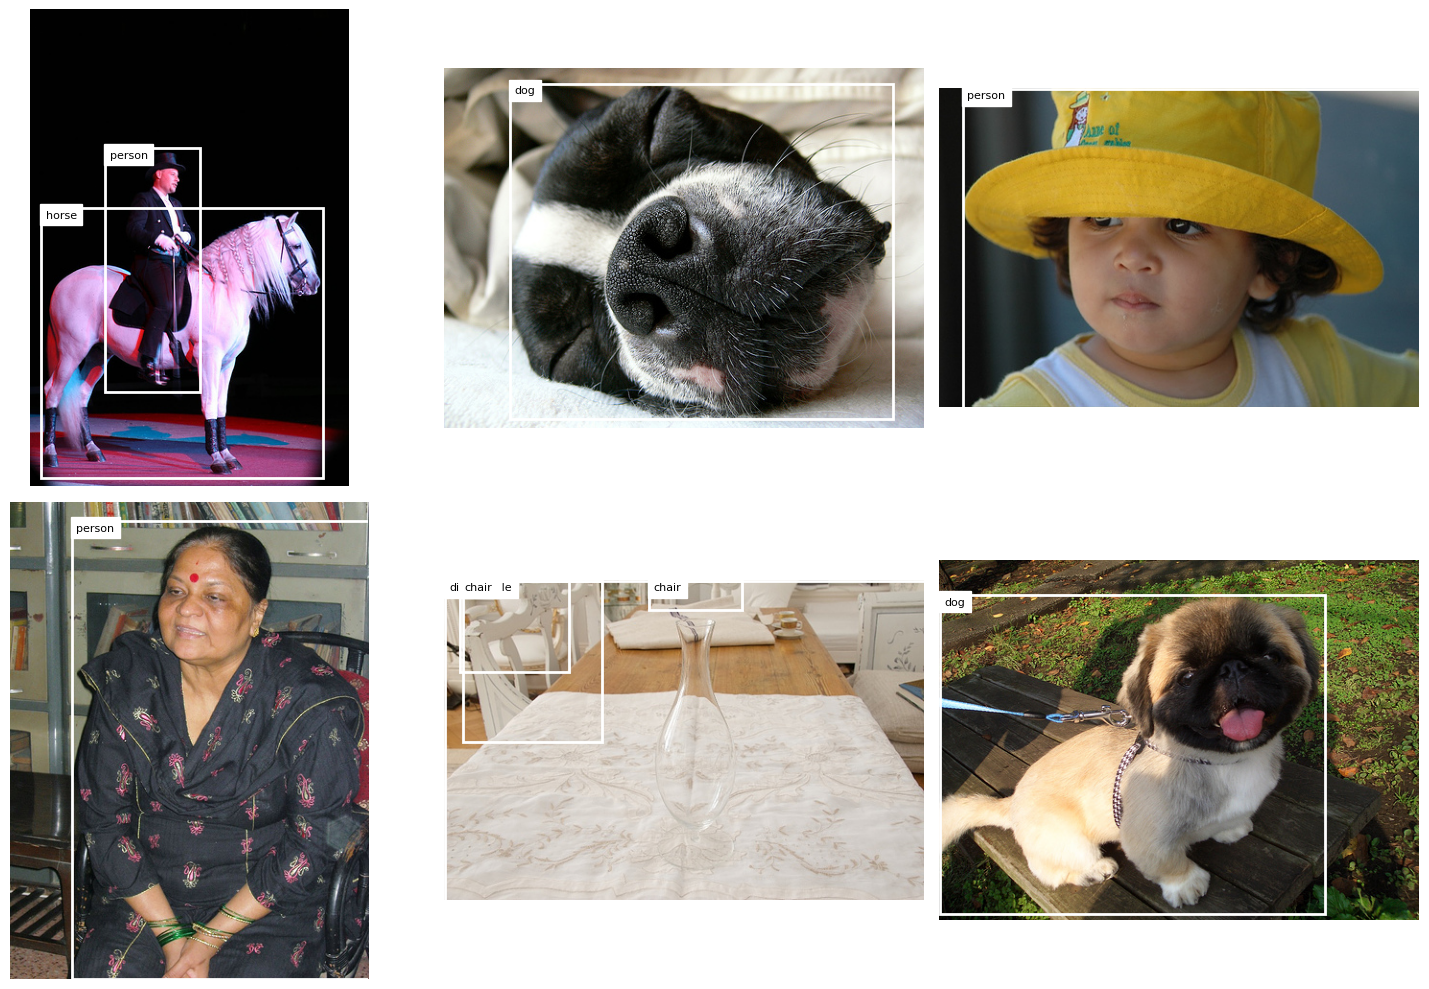

In [13]:
show_imgs('data/train.json', 2, id2label, id2img)

In [14]:
with open('data/valid.json', 'r') as f:
    valid_data = json.load(f)

valid_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [15]:
def load_data(ann_file, imgs_folder):
    data = json.load(open(ann_file))

    id2label = {d['id']:d['name'] for d in data['categories']}
    id2img = {d['id']:f"{imgs_folder}/{d['file_name']}" for d in data['images']}

    df = pd.DataFrame(data['annotations'])
    df = df.query('ignore!=1').drop(columns=['segmentation','ignore'])
    agg_df = df.groupby('image_id').agg(list).reset_index()
    return agg_df, id2label, id2img

In [16]:
agg_df, id2label, id2img = load_data(ann_file='data/train.json', imgs_folder='data/train')

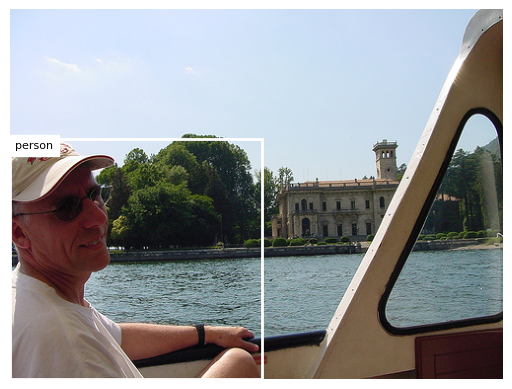

In [17]:
img_id, gtbbs, cat_ids = agg_df.loc[100, ['image_id','bbox','category_id']]
img_path = id2img[img_id]
labels = [id2label[id] for id in cat_ids]

show_bbs(img_path, gtbbs, labels)

In [40]:
def make_json_file(path, df):
    exp_df = df.explode(df.columns.drop('image_id').tolist())
    exp_df['ignore'] = 0
    exp_df['segmentation'] = [[0]*4 for _ in range(len(exp_df))]
    
    ann_data = exp_df.to_dict(orient='records')
    imgs_data = [{'id':k, 'file_name':v.split('/')[-1]} for k,v in id2img.items()]
    cat_data = [{'id':k, 'name':v} for k,v in id2label.items()]
    
    data = {'categories':cat_data,'annotations':ann_data,'images':imgs_data}
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)

In [41]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(agg_df, test_size=0.1)

In [42]:
make_json_file('tmp/train.json', train_df)

make_json_file('tmp/valid.json', valid_df)

In [43]:
import torch
from torchvision.ops import batched_nms

def perform_nms(preds, thresh=0.5):
    ids, bbs, scores = preds[['category_id','bbox','score']]
    ids, bbs, scores = [torch.tensor(l, dtype=torch.float32) for l in [ids, bbs, scores]]
    ids, bbs, scores = [t[ids!=0] for t in [ids, bbs, scores]]
    boxes = torch.cat([bbs[:,:2], bbs[:,:2]+bbs[:,2:]-1], dim=1)
    idxs = batched_nms(boxes, scores, ids, thresh)
    preds[['category_id','bbox','score']] = [t[idxs].tolist() for t in [ids, bbs, scores]]
    return preds

In [55]:
anns = (json.load(open('tmp/valid.json')))['annotations']
preds = pd.DataFrame(anns)
preds = preds.drop(columns=['area','iscrowd','id','ignore','segmentation'])
preds['score'] = 0.995

In [56]:
preds = preds.groupby('image_id').agg(list).reset_index()
preds = preds.apply(perform_nms, axis=1)

In [58]:
preds = preds.explode(preds.columns.drop('image_id').tolist())
preds.to_json('tmp/valid_preds.json', orient='records')

In [59]:
import io, sys
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def calc_mAP(gt_path, pred_path):
    with io.StringIO() as buf:
        save_stdout = sys.stdout
        sys.stdout = buf  # Redirect standard output
        coco_gt = COCO(gt_path)
        coco_pred = coco_gt.loadRes(pred_path)
        cocoEval = COCOeval(coco_gt, coco_pred, 'bbox')
        cocoEval.evaluate(); cocoEval.accumulate(); cocoEval.summarize()
        sys.stdout = save_stdout  # Restore standard output
    return cocoEval.stats[0]

In [60]:
calc_mAP('tmp/valid.json', 'tmp/valid_preds.json')

np.float64(0.995049504950495)